In [44]:
import numpy as np
import pandas as pd
import random
import math

# 必要なデータの設定
required_times = [5, 7, 2, 3, 3, 2, 23, 30]  # 各アトラクションの所要時間
popularity = [476, 465, 473, 472, 480, 452, 461, 478]  # 各アトラクションの人気度
move_time = 15  # 移動時間

# CSVデータの読み込み
file_path = 'combined_data.csv'
# print(file_path)
data = pd.read_csv(file_path)


# '最適プラン'をリストに変換
data['最適プラン'] = data['最適プラン'].apply(lambda x: list(map(int, x.strip('[]').split(', '))))


# シミュレーテッドアニーリングの関数定義
def simulated_annealing(data, required_times, popularity, move_time, max_iter=1000, initial_temp=1000, cooling_rate=0.99):
    current_plan = data['最適プラン'][0]
    best_plan = current_plan
    best_score = data['トータル満足度'][0]

    temp = initial_temp
    for i in range(max_iter):
        new_plan = generate_neighbor(current_plan)
        new_score = calculate_score(new_plan, popularity)
        current_score = calculate_score(current_plan, popularity)

        if new_score > current_score or math.exp((new_score - current_score) / temp) > random.random():
            current_plan, current_score = new_plan, new_score
            if new_score > best_score:
                best_plan, best_score = new_plan, new_score

        temp *= cooling_rate

    return best_plan, best_score

# 隣接プランの生成関数
def generate_neighbor(plan):
    new_plan = plan.copy()
    idx1, idx2 = random.sample(range(len(plan)), 2)
    new_plan[idx1], new_plan[idx2] = new_plan[idx2], new_plan[idx1]
    return new_plan

# 評価関数（満足度の計算）
def calculate_score(plan, popularity):
    return sum([popularity[i] for i in plan])

# 行数を指定すると所用時間を返す関数
def knapsack(row_x, data_x,required_time_x, waiting_time_x, move_time_x, attraction_no_x):
    waiting_time_x = data_x.iloc[row_x, attraction_no_x]
    ans = required_time_x + waiting_time_x + move_time_x
    return ans


# 合計所要時間と合計人気度を算出する関数
def ride_calculation(data, ride_lst, required_times, popularity, move_time):
    # print(data)
    # print(ride_lst)
    # print(required_times)
    # print(move_time)
    total_popularity = 0
    total_time = 0
    ride_time = []
    new_ride_lst = []
    # start_time = data.index[0]
    # print("start time is:", calculate_time(start_time))
    row = 0
    try:
        c=0
        for i in ride_lst:
            # total_timeが675以上かつiが0または1の場合にループを強制終了
            # ソアリン、トイストーリーMは20:15以降DPA所持者のみ乗車可能
            if (data.index[row]) >= 675 and (i == 0 or i == 1):
                c+=1
                continue
            
            else:
                # iが8以上の場合、次のループへ(該当しないアトラクション)
                if i >= 8 or i < 0:
                    # print("不明なアトラクション：", i)
                    c+=1
                    continue
                elif c>0 and i==ride_lst[c-1]:
                    c+=1
                    continue
                else:
                    # print("-" * 40)
                    # print(calculate_time(data.index[row]))
                    ride_time.append(data.index[row])
                    # print(attractions.get(i))
                    # print("移動時間", move_time)
                    waiting_time = data.iloc[row, i]
                    # print("待ち時間:", waiting_time)
                    required_time = required_times[i]
                    # print("観賞時間:", required_time)
                    ans = knapsack(row, data, required_time, waiting_time, move_time, i)
                    # print("合計所要時間:", ans)
                    total_time += ans
                    row = int(np.ceil(total_time / 15))
                    total_popularity += popularity[i]
                    new_ride_lst.append(i)
                    c+=1
    except Exception as e:
        # print("全てのアトラクションを乗ることができません")
        pass

    # print("-" * 40)
    # print(total_popularity)
    return total_popularity, total_time, new_ride_lst, ride_time


# シミュレーテッドアニーリングの実行
best_plan, best_score = simulated_annealing(data, required_times, popularity, move_time)

# 検証したい待ち時間データを選ぶ
# CSVデータの読み込み
file_path = './date_data2/2022-07-01.csv'
date_data = pd.read_csv(file_path)
date_data = date_data.set_index('時間')

# 最適プランをride_calculation関数に渡して所要時間と人気度を計算
total_popularity, total_time, new_ride_lst, ride_time = ride_calculation(date_data, best_plan, required_times, popularity, move_time)

# ファイル名から日付を取得
date = os.path.basename(file_path).replace('.csv', '')

# データフレームの作成
output_df = pd.DataFrame({
    '日付': [date],
    'トータル満足度': [best_score],
    'トータル所要時間': [total_time],
    '予定プラン': [best_plan],
    '最適プラン': [best_plan],
    'タイムスケジュール': [ride_time]
})

display(output_df)


,日付,トータル満足度,トータル所要時間,予定プラン,最適プラン,タイムスケジュール
0,2022-07-01,6074.0,542,"[5, 6, 4, 2, 7, 5, 4, 3, 4, 6, 5, 6, 3]","[5, 6, 4, 2, 7, 5, 4, 3, 4, 6, 5, 6, 3]","[0, 30, 60, 105, 165, 225, 255, 300, 345, 375,..."


In [47]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import os
import math
import re
import ast
import matplotlib.pyplot as plt
# 日本語フォントを使用する
plt.rcParams['font.family'] = 'IPAexGothic'

attractions = {
    0: 'ソアリン',
    1: 'トイストーリーマニア',
    2: 'タワーオブテラー',
    3: 'センターオブジアース',
    4: 'インディージョーンズ',
    5: 'レイジングスピリッツ',
    6: 'マジックランプシアター',
    7: 'タートルトーク'
}

In [50]:
# 分を24時間表示に変換
def calculate_time(minutes):
    # 9:00 を0分、20:00 を660分として計算
    start_time = 9 * 60  # 9:00を分単位に変換
    end_time = 20 * 60  # 20:00を分単位に変換
    
    total_minutes = start_time + minutes
    
    # 時間と分に変換
    hours = total_minutes // 60
    mins = total_minutes % 60
    
    # 24時間表記に変換
    if hours >= 24:
        hours -= 24
    
    # 時間と分を文字列に変換して返す
    return f"{hours:02d}:{mins:02d}"

In [51]:
# 24時間表示を分に変換
def calculate_minutes(time_str):
    # 時刻を時間と分に分割
    hours, mins = map(int, time_str.split(":"))
    
    # 9:00 を0分、20:00 を660分として計算
    start_time = 9 * 60  # 9:00を分単位に変換
    end_time = 20 * 60  # 20:00を分単位に変換
    
    # 入力された時刻を分単位に変換
    total_minutes = hours * 60 + mins
    
    # 24時間以上の場合は調整
    if total_minutes < start_time:
        total_minutes += 24 * 60
    
    # 開始時刻からの経過時間を計算
    elapsed_minutes = total_minutes - start_time
    
    return elapsed_minutes

In [54]:
import matplotlib.pyplot as plt
import pandas as pd
import ast

def plot_time_schedule(df_data, num_samples=10):
    # CSVファイルからデータを読み込む
    df = df_data

    # 最初の num_samples 個のデータのみを抽出
    df_sample = df.head(num_samples)

    # "最適プラン" と "タイムスケジュール" colのデータを取得
    optimal_plans_list = [ast.literal_eval(plan) if isinstance(plan, str) else plan for plan in df_sample["最適プラン"]]
    time_schedule_list = [ast.literal_eval(plan) if isinstance(plan, str) else plan for plan in df_sample["タイムスケジュール"]]

    # カラーマップを定義
    num_colors = len(optimal_plans_list)
    colors = plt.cm.get_cmap('tab10', num_colors)

    # プロットの準備
    plt.figure(figsize=(18, 10))  # グラフのサイズを広く設定

    # optimal_plans_list と time_schedule_list のデータをプロット
    for i in range(len(optimal_plans_list)):
        plt.plot(time_schedule_list[i], optimal_plans_list[i], marker='o', linestyle='-', 
                 label=f'Data {i+1}', color=colors(i))

    # グラフの設定
    plt.xlabel('時間軸', fontsize=14)
    plt.ylabel('アトラクションインデックス', fontsize=14)
    plt.title(f'最適プランとタイムスケジュールの折れ線グラフ ({num_samples} samples)', fontsize=16)
    plt.legend(loc='best', fontsize=12)
    plt.grid(True)

    # x軸の範囲を調整（必要に応じて）
    plt.xlim(0, 705)  # 例として幅を広く設定

    # y軸の範囲を調整（必要に応じて）
    plt.ylim(0, 7)
    plt.yticks(range(8), [attractions[i] for i in range(8)], fontsize=10)

    # x軸にアトラクションの名称を設定
    x_ticks = range(0, 706, 15)
    x_labels = [f'{calculate_time(tick)}' for tick in x_ticks]
    plt.xticks(x_ticks, x_labels, rotation=45, fontsize=8)
    
    # グラフの表示
    plt.tight_layout()
    plt.show()

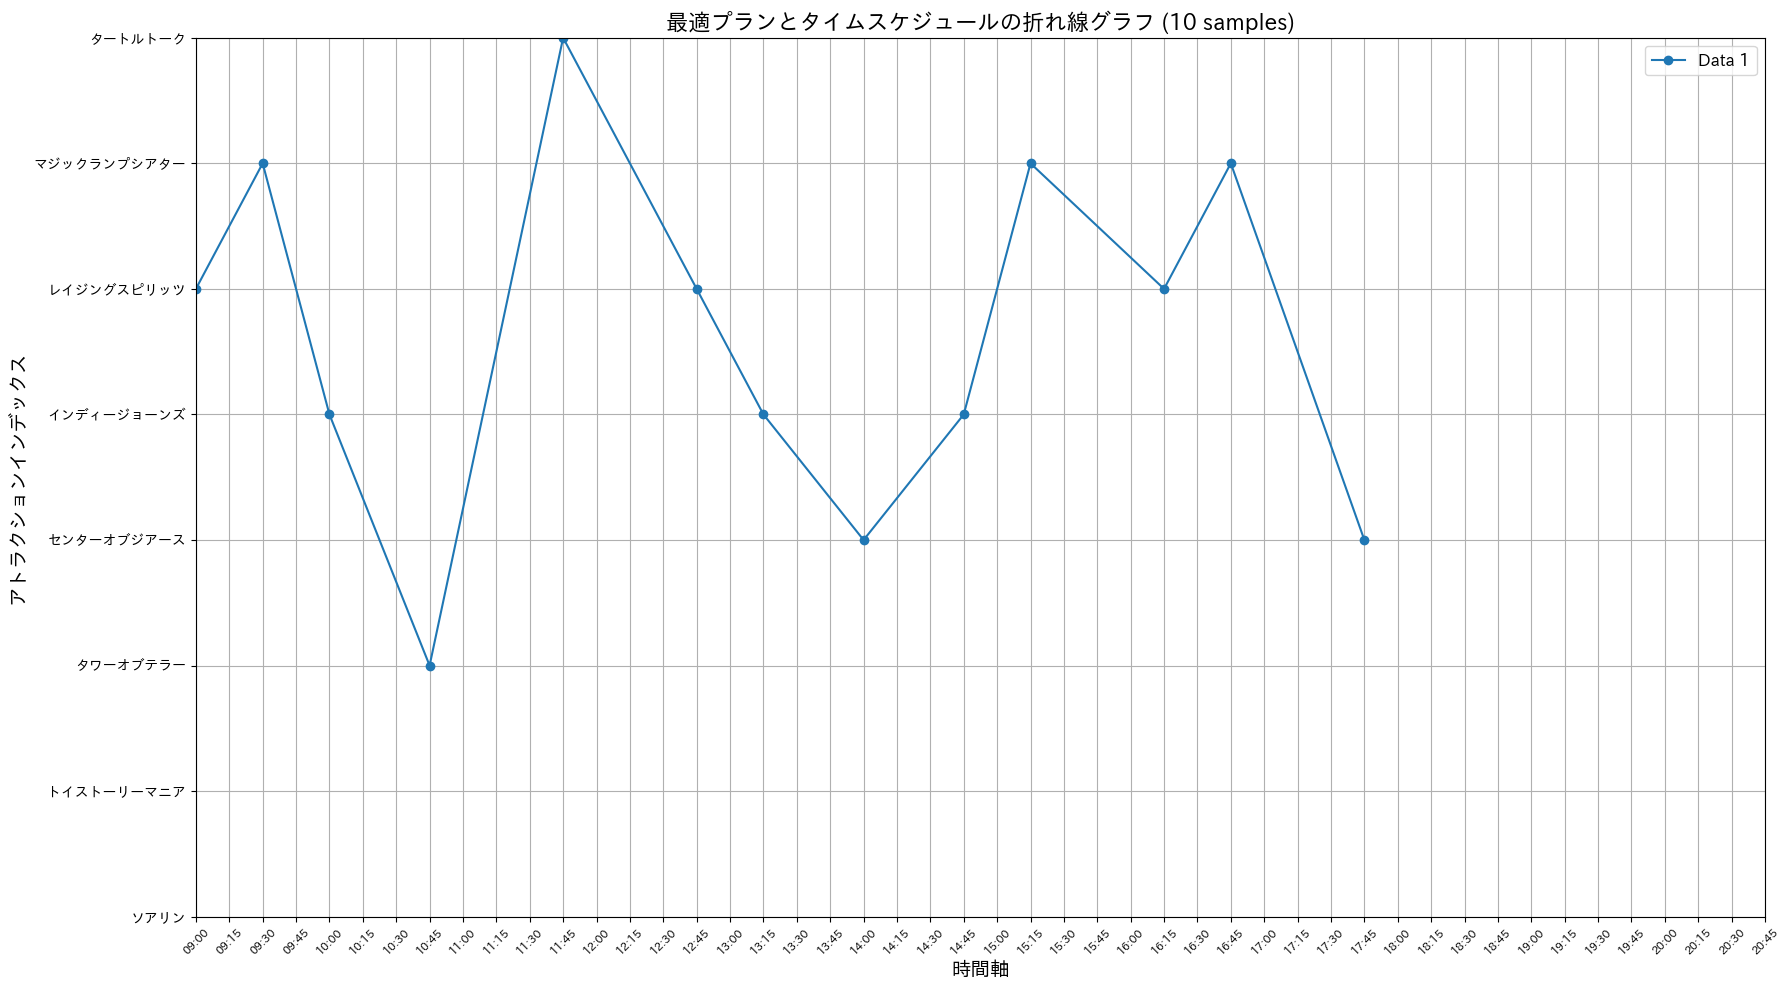

In [55]:
# 関数の呼び出し
plot_time_schedule(output_df, num_samples=10)